In [1]:
from tree_detection_framework.preprocessing.preprocessing import (
    create_dataloader,
    visualize_dataloader,
)
from tree_detection_framework.detection.detector import GeometricDetector
from tree_detection_framework.postprocessing.postprocessing import postprocess_detections

/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
dataloader = create_dataloader(
    raster_folder_path="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/chm.tif",
    chip_size=512,
    chip_stride=400,
    batch_size=3,
    output_resolution=0.2,
)

2024-12-03 19:50:11,260 - INFO - Units = Units.PIXELS
2024-12-03 19:50:11,261 - INFO - Stride = 400


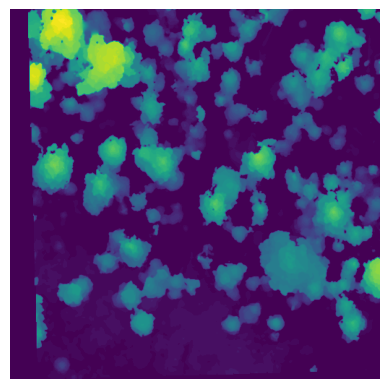

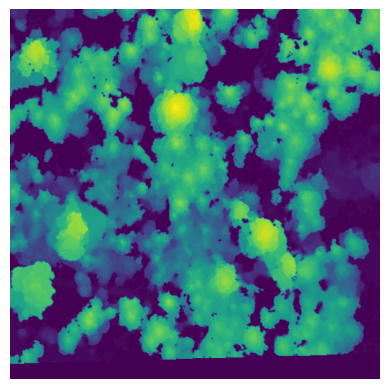

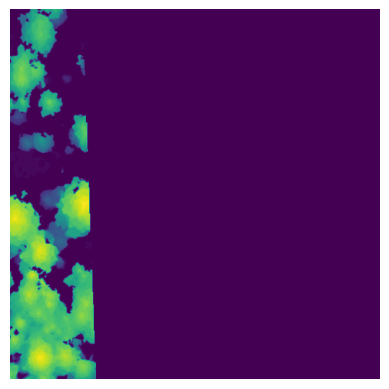

In [3]:
visualize_dataloader(dataloader, 3)

In [3]:
detector = GeometricDetector(a=0.0045, res=dataloader.sampler.res)
predictions = detector.predict(dataloader)

Performing prediction on batches: 100%|██████████| 6/6 [01:40<00:00, 16.77s/it]


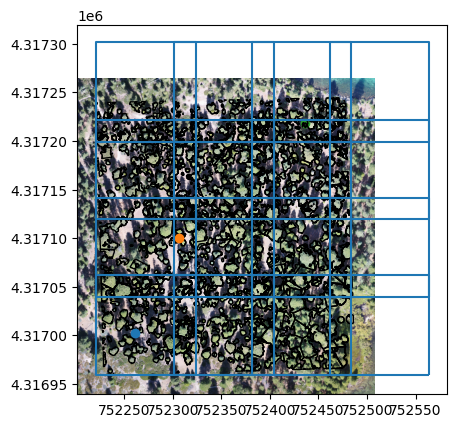

<Axes: >

In [4]:
predictions.plot(
    raster_file="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/ortho.tif"
)

Postprocessing
--

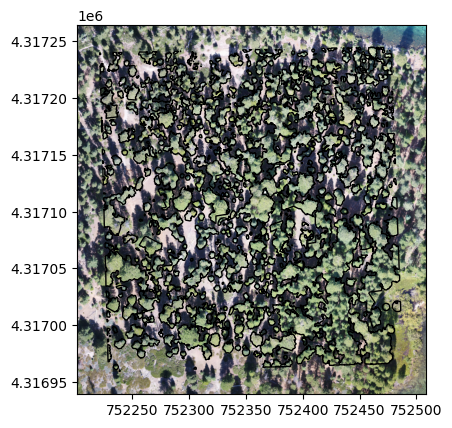

<Axes: >

In [7]:
postprocessed = postprocess_detections(predictions, crs=dataloader.dataset.crs)

postprocessed.plot(
    raster_file="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/ortho.tif"
)

In [8]:
postprocessed.save("/ofo-share/repos-amritha/extras/postprocessed_geometric_detections.gpkg")

2024-12-03 19:58:33,581 - INFO - Created 618 records
